# R C3X fidelity check

23 Dec 2019

origined by rum

---
In this code, two types of R-Toffoli gate are checked fidelity on real device

In [1]:
## import tools
## Import numpy 
import numpy as np
from numpy import pi

## import plot tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
## To plot heatmap
import seaborn as sns

## import datetime
from datetime import datetime

## Import qiskit tools
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

## import qiskit backend monitor
from  qiskit.tools.monitor import backend_monitor

## import qiskit readout error mitigation tools
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

---
# 1. Get device

In [2]:
IBMQ.load_account()

/Users/Yasuhiro/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### Here to choose provider

In [3]:
## keio-internal device
provider = IBMQ.get_provider(hub='ibm-q-keio', group='keio-internal', project='keio-students')

## reservations
# provider = IBMQ.get_provider(hub='ibm-q-keio', group='keio-internal', project='reservations')

## open device
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

### Define the backend device

In [4]:
device = provider.get_backend("ibmq_ourense")

---
# 2. Define circuit

### 2-1. Define R-Toffoli as function

---
### R-Toffoli_m
<img src="../img/RToffoli_m.png" />

In [5]:
## define RTof function
def RTof_m(qc, c1, c2, t):
    qc.ry(pi/4, t)
    qc.cx(c2, t)
    qc.ry(pi/4, t)
    qc.cx(c1, t)
    qc.ry(-pi/4, t)
    qc.cx(c2, t)
    qc.ry(-pi/4, t)

---
### R-Toffoli_ix
<img src="../img/RToffoli_ix.png" />

In [6]:
def RTof_ix(qc, c1, c2, t):
#     qc.h(t)
#     qc.t(t)
    qc.u2(pi/4, pi, t)
    qc.cx(c2, t)
    qc.tdg(t)
    qc.cx(c1, t)
    qc.t(t)
    qc.cx(c2, t)
#     qc.tdg(t)
#     qc.h(t)
    qc.u2(0, 3*pi/4, t)

---
### Toffoli gate with one swap
<img src = "../img/Toffoli_SWAP.png" />

In [7]:
## Toffoli gate with one swap
def Toffoli_SWAP(circuit, control1,  control2, target):
    
    """
    c1, c2, t => c1, t, c2
    """
    
    circuit.h(target)
    circuit.cx(control1, target)
    circuit.tdg(target)
    circuit.cx(control2, target)
    circuit.t(target)
    circuit.cx(control1, target)
    circuit.tdg(target)
    circuit.cx(target, control2) ## SWAP
    circuit.cx(control2, target) ## SWAP
    circuit.t(control1)
    circuit.t(control2)
    circuit.cx(target ,control1)
    circuit.tdg(control1)
    circuit.h(control2)
    circuit.t(target)
    circuit.cx(target, control1)

### 2-2. Compose circuit

In [8]:
## define qubit label as num_qubits
num_qubits = len(device.configuration().gates[0].coupling_map)


## Define the list to store the circuit lists of each qubits of the processor
RTof_qc = []

## define init_list
init_list = [format(j, '03b') for j in range(8)]


## define qubit
c1, c2, targ = [0, 1, 2]

In [9]:
## repeat circuit definition for each init_list
for init in init_list:

    ## define circuit
    qr = QuantumRegister(3, "q")
    cr = ClassicalRegister(3, "c")
    circuit = QuantumCircuit(qr, cr)

    ## Initialization
    if(init[0] == '1'):
        circuit.x(qr[c1])
    if(init[1] == '1'):
        circuit.x(qr[c2])
    if(init[2] == '1'):
        circuit.x(qr[int(targ)])

    ## R-Tof_m
    RTof_m(circuit, qr[c1], qr[c2], qr[targ])
    
    ## insert barrier between gates and measurement
    circuit.barrier()

    ## measure the qubit
    circuit.measure(qr[c1], cr[2])
    circuit.measure(qr[c2], cr[1])
    circuit.measure(qr[targ], cr[0])

    ## Append the circuit to the init_list_qc list
    RTof_qc.append(circuit)

In [10]:
## repeat circuit definition for each init_list
for init in init_list:

    ## define circuit
    qr = QuantumRegister(3, "q")
    cr = ClassicalRegister(3, "c")
    circuit = QuantumCircuit(qr, cr)

    ## Initialization
    if(init[0] == '1'):
        circuit.x(qr[c1])
    if(init[1] == '1'):
        circuit.x(qr[c2])
    if(init[2] == '1'):
        circuit.x(qr[int(targ)])

    ## R-Tof_m
    RTof_ix(circuit, qr[c1], qr[c2], qr[targ])
    
    ## insert barrier between gates and measurement
    circuit.barrier()

    ## measure the qubit
    circuit.measure(qr[c1], cr[2])
    circuit.measure(qr[c2], cr[1])
    circuit.measure(qr[targ], cr[0])

    ## Append the circuit to the init_list_qc list
    RTof_qc.append(circuit)

In [11]:
## repeat circuit definition for each init_list
for init in init_list:

    ## define circuit
    qr = QuantumRegister(3, "q")
    cr = ClassicalRegister(3, "c")
    circuit = QuantumCircuit(qr, cr)

    ## Initialization
    if(init[0] == '1'):
        circuit.x(qr[c1])
    if(init[1] == '1'):
        circuit.x(qr[c2])
    if(init[2] == '1'):
        circuit.x(qr[int(targ)])

    ## R-Tof_m
    Toffoli_SWAP(circuit, qr[c1], qr[c2], qr[targ])
    
    ## insert barrier between gates and measurement
    circuit.barrier()

    ## measure the qubit
    circuit.measure(qr[c1], cr[2])
    circuit.measure(qr[c2], cr[0])
    circuit.measure(qr[targ], cr[1])

    ## Append the circuit to the init_list_qc list
    RTof_qc.append(circuit)

In [12]:
RTof_qc[0].draw()

---
# 3. Run on QASM simulator

### 3-1. Execution

In [13]:
## define simulator
simulator = Aer.get_backend("qasm_simulator")

## define shots
shots = 8192

## define repeat length
in_len = len(init_list)

## define job
job_sim = execute(RTof_qc, backend = simulator, shots = shots)
result_sim = job_sim.result()


## define the list to imidiately store the counts of the each circuit
## repeat # of each angle circuits times
counts_sim_m = [result_sim.get_counts(init) for init in range(in_len)]
counts_sim_ix = [result_sim.get_counts(init) for init in range(in_len, 2*in_len)]
counts_sim_swap = [result_sim.get_counts(init) for init in range(2*in_len, 3*in_len)]

In [14]:
print('counts_sim_m = ', counts_sim_m)

counts_sim_m =  [{'000': 8192}, {'001': 8192}, {'010': 8192}, {'011': 8192}, {'100': 8192}, {'101': 8192}, {'111': 8192}, {'110': 8192}]


In [15]:
print('counts_sim_ix = ', counts_sim_ix)

counts_sim_ix =  [{'000': 8192}, {'001': 8192}, {'010': 8192}, {'011': 8192}, {'100': 8192}, {'101': 8192}, {'111': 8192}, {'110': 8192}]


In [16]:
print('counts_sim_swap = ', counts_sim_swap)

counts_sim_swap =  [{'000': 8192}, {'001': 8192}, {'010': 8192}, {'011': 8192}, {'100': 8192}, {'101': 8192}, {'111': 8192}, {'110': 8192}]


### 3-2. Plot the result

In [17]:
## define length of repeat
input_len = len(counts_sim_m)
output_bin = [format(num, '03b') for num in range(8)]


sim_data_m = [[(counts_sim_m[inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)]
sim_data_ix = [[(counts_sim_ix[inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)]
sim_data_swap = [[(counts_sim_swap[inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)]

In [18]:
print(sim_data_swap)

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]]


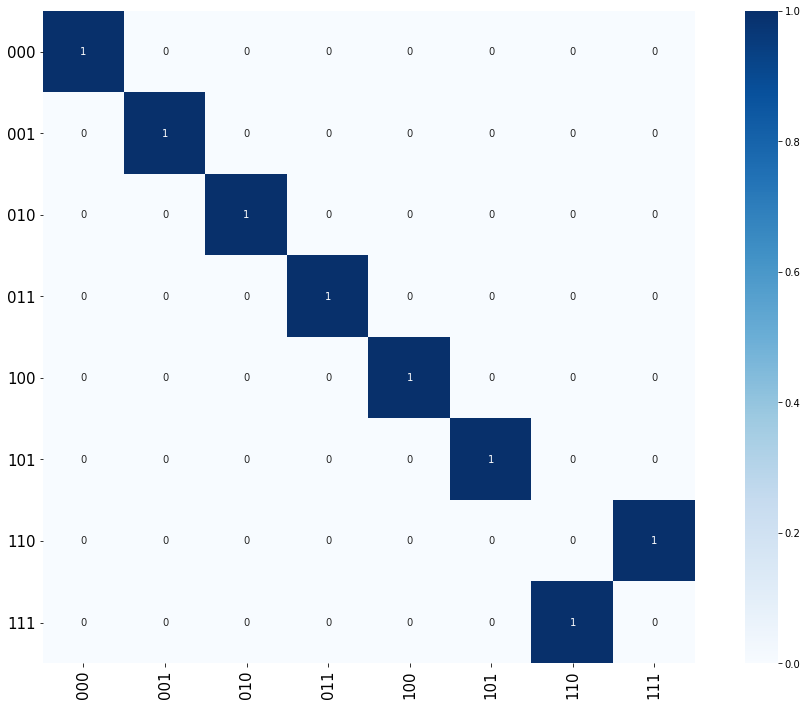

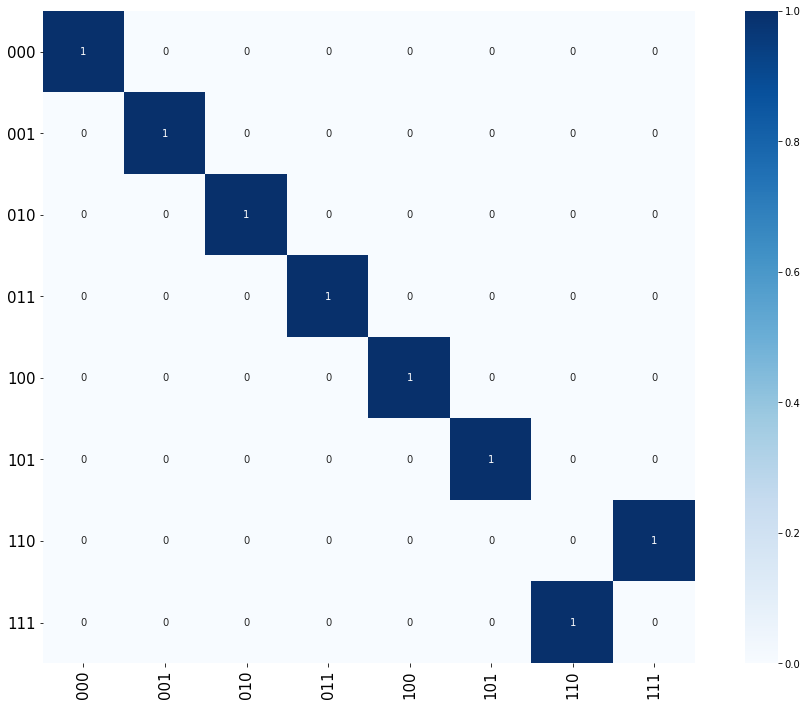

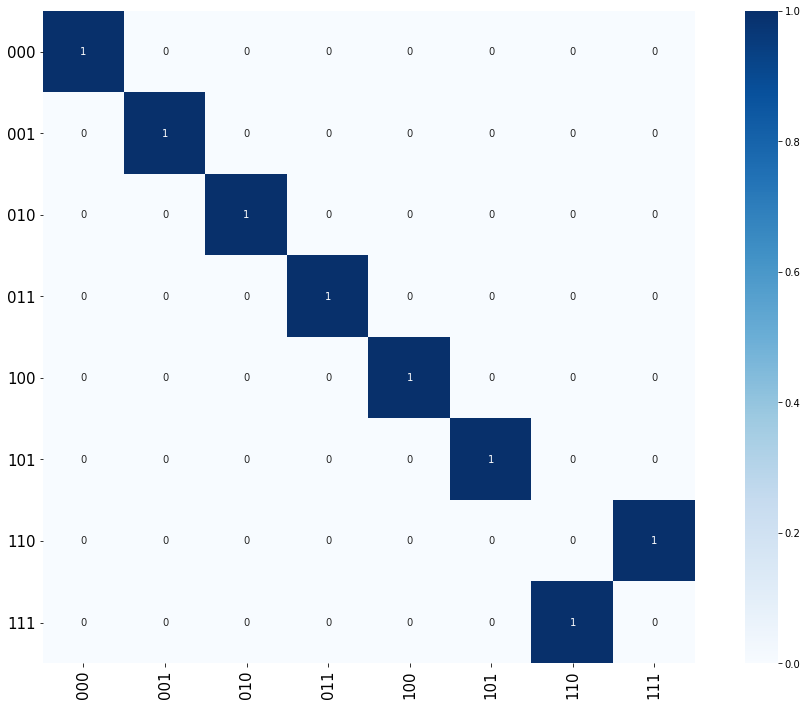

In [19]:
## axix range and data labels
### axix range
length=[num+0.5 for num in range(8)]
### labels 
X = [format(num, "03b") for num in range(8)]
Y = X

for sim_data in [sim_data_m, sim_data_ix, sim_data_swap]:
    ## set size
    fig,ax = plt.subplots(figsize=(18, 12))
    
    ## plot data
    sns.heatmap(sim_data, 
                vmin = 0.0,  ## define maximum value
                vmax=1.0,   ## defnie minimum value
                annot=True, ## show the numerical data
                square=True,  ## set heatmap to square shape
                cmap=plt.get_cmap('Blues') ## define the color
               )

    ## axis
    plt.xticks(length, 
               X, 
               rotation=90, 
               fontsize=15
              )
    plt.yticks(length, 
               Y, 
               rotation=0, 
               fontsize=15)
    
    plt.show()

---
# 4. Run on Realdevice

In [20]:
backend_monitor(device)

ibmq_ourense
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 40
    backend_version: 1.0.1
    basis_gates: ['u1', 'u2', 'u3', 'cx', 'id']
    local: False
    simulator: False
    coupling_map: [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]
    quantum_volume: 8
    allow_q_object: True
    url: None
    sample_name: Giraffe
    max_experiments: 75
    credits_required: True
    max_shots: 8192
    open_pulse: False
    memory: True
    description: 5 qubit device Ourense
    conditional: False
    allow_q_circuit: False
    online_date: 2019-07-03T04:00:00+00:00
    backend_name: ibmq_ourense
    n_registers: 1
    allow_object_storage: True

Qubits [Name / Freq / T1 / T2 / U1 err / U2 err / U3 err / Readout err]
-----------------------------------------------------------------------
    Q0 / 4.81949 GHz / 79.24424 µs / 64.19342 µs / 0.0 / 0.0004 / 0.00081 / 0.021
    Q1 / 4.89124 GHz / 102.86431 µs / 34.984

### 4-1. finding the qubit mapping list

In [21]:
## Get qubit coupling map
conf = device.configuration()
coupling_map = conf.coupling_map
print(coupling_map)

[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]


In [22]:
## searching the qubit mapping list from coupling_map
#
#
import numpy as np
from collections import Counter
from copy import copy

## get qubit coupling_map from configuraion
conf=device.configuration()
coupling_map = conf.coupling_map


hub_list = []
adj_qubit_list=[]
qubit_mapping=[]

## finding hubs of mapping
counter = Counter(np.ravel(coupling_map))
for qubit, cnt in counter.most_common():
#     print(qubit, ":", cnt)
    if(cnt>=4):
        hub_list.append([qubit]) 

## finding the adjacency qubits of hub-qubit
for hub in hub_list:
    adj_list=[]
    for con in range(len(coupling_map)):
        if(coupling_map[con][0]==hub[0]):
            adj = coupling_map[con][1]
            
            ## append adjacency qubit
            adj_list.append(adj)
    adj_qubit_list.append([hub[0], adj_list])
# print(adj_qubit_list)

## sorting the arrangement
for hub in adj_qubit_list:
    for c1 in range(len(hub[1])):
        for c2 in range(len(hub[1])):
            if hub[1][c2] != hub[1][c1]:
                mapping = []
                mapping.append(hub[1][c1])
                mapping.append(hub[1][c2])
                mapping.append(hub[0])
#                 print(mapping)
                
                qubit_mapping.append(mapping)
        
print("qubit_mapping = ", qubit_mapping)

qubit_mapping =  [[0, 2, 1], [0, 3, 1], [2, 0, 1], [2, 3, 1], [3, 0, 1], [3, 2, 1], [1, 4, 3], [4, 1, 3]]


### 4-2. Define mitigation circuit

In [23]:
qr = QuantumRegister(3)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [24]:
print(meas_calibs)
print(state_labels)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2310f908>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2310f860>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2310fcc0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2310f0f0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2310fc50>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a23113240>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a231130f0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a23113358>]
['000', '001', '010', '011', '100', '101', '110', '111']


### 4-3. Execution

In [25]:
# ## define shots
# shots = 8192

# ## define the lists to store job_id
# job_id_list = []
# cal_job_id_list = []

# ## repeat # of qubit_mapping times
# for mapping in qubit_mapping:
    
#     ## job for circuit execution
#     job_exp = execute(RTof_qc,
#                       backend = device, 
#                       shots = shots,
#                       initial_layout=mapping,
#                       optimization_level = 0
#                      )
#     job_id_list.append(job_exp.job_id())
#     print('sent the job', mapping)

    
#     ## job for meas_cal
#     cal_job = execute(meas_calibs, 
#                     backend = device,
#                     shots=shots,
#                     initial_layout=mapping,
#                     optimization_level=0
#                     )
#     cal_job_id_list.append(cal_job.job_id())
#     print('sent the cal_job', mapping)
    
# #     ## get results
# #     result_exp = job_exp.result()
# #     result_cal = cal_job.result()
    
# #     result_exp_list.append(result_exp)
# #     result_cal_exp_list.append(result_cal)

# print('job_id_list = ', job_id_list)
# print('cal_job_id_list = ', cal_job_id_list)

In [26]:
job_id_list =  ['5e01cd4e27f7840012679bc3', '5e01cd55619aa80011ca5f17', '5e01cd5a27f7840012679bc4', '5e01cd5e2b1101001312bfcd', '5e01cd6376be6000126d8cab', '5e01cd672b1101001312bfcf', '5e01cd6cc3b5500011d5315c', '5e01cd7131ea3200124695d9']
cal_job_id_list =  ['5e01cd52619aa80011ca5f16', '5e01cd57619aa80011ca5f18', '5e01cd5c03bd6f001205b9fe', '5e01cd6103bd6f001205ba00', '5e01cd65c3b5500011d5315b', '5e01cd6903bd6f001205ba02', '5e01cd6ec3b5500011d5315e', '5e01cd7327f7840012679bc6']

### 4-4. retrieve the job and get the result

In [27]:
        ## Define the list to store the result_exp for error mitigation
result_exp_list = []
result_cal_exp_list = []

for job_id, cal_job_id in zip(job_id_list, cal_job_id_list) :
    ## retrieve jobs
    retrieved_job = device.retrieve_job(job_id)
    retrieved_cal_job = device.retrieve_job(cal_job_id)
    print("jobs were retrieved")
    result_exp = retrieved_job.result()
    print("got exp result")
    result_cal_exp = retrieved_cal_job.result()
    print("got cal_exp result")
    ## Append results_exp to the result_exp_list for error mitigation operation
    result_exp_list.append(result_exp)
    result_cal_exp_list.append(result_cal_exp)

print(result_exp_list)
print(result_cal_exp_list)

jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
[Result(backend_name='ibmq_ourense', backend_version='1.0.1', date=datetime.datetime(2019, 12, 24, 8, 37, 52, tzinfo=datetime.timezone.utc), execution_id='493b4de4-2628-11ea-80b5-ac1f6b47c318', header=Obj(backend_name='ibmq_ourense', backend_version='1.0.1'), job_id='5e01cd4e27f7840012679bc3', qobj_id='9849cdff-5fb0-492a-a29d-b5a0813bf46b', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x0=7416, 0x1=506, 0x2=118, 0x3=20, 0x4=115, 0x5=13, 0x6=2, 0x7=2)), header=Obj(clbit_labels=[['c', 0], ['c', 1], ['c', 2]], creg_sizes=[['c', 3]], memory_slots=3

# Readout Error mitigation

The calibration matrix 

[[9.54833984e-01 3.39355469e-02 2.63671875e-02 1.58691406e-03
  3.45458984e-02 7.32421875e-04 1.09863281e-03 0.00000000e+00]
 [1.08642578e-02 9.32983398e-01 1.22070312e-04 3.02734375e-02
  7.32421875e-04 3.78417969e-02 0.00000000e+00 1.58691406e-03]
 [9.76562500e-03 4.88281250e-04 9.35913086e-01 3.14941406e-02
  6.10351562e-04 0.00000000e+00 3.74755859e-02 1.95312500e-03]
 [1.22070312e-04 9.39941406e-03 1.19628906e-02 8.79394531e-01
  1.22070312e-04 3.66210938e-04 4.88281250e-04 3.41796875e-02]
 [2.38037109e-02 9.76562500e-04 1.22070312e-03 1.86767578e-02
  9.41894531e-01 3.57666016e-02 2.62451172e-02 2.44140625e-03]
 [4.88281250e-04 2.22167969e-02 1.22070312e-04 3.17382812e-03
  1.12304688e-02 9.14184570e-01 1.22070312e-04 2.95410156e-02]
 [0.00000000e+00 0.00000000e+00 2.39257812e-02 3.41796875e-03
  1.06201172e-02 4.88281250e-04 9.23828125e-01 3.93066406e-02]
 [1.22070312e-04 0.00000000e+00 3.66210938e-04 3.19824219e-02
  2.44140625e-04 1.06201172e-02 1.0742

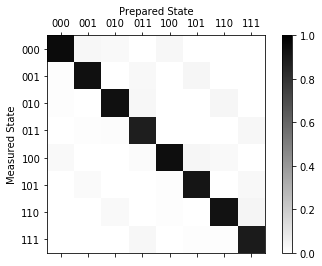

Average Measurement Fidelity: 0.921753 

The calibration matrix 

[[9.34570312e-01 3.30810547e-02 8.60595703e-02 2.19726562e-03
  4.19921875e-02 1.58691406e-03 4.15039062e-03 0.00000000e+00]
 [1.06201172e-02 9.16625977e-01 2.92968750e-03 8.32519531e-02
  4.88281250e-04 4.23583984e-02 1.22070312e-04 4.51660156e-03]
 [2.23388672e-02 1.58691406e-03 8.73168945e-01 3.22265625e-02
  1.58691406e-03 0.00000000e+00 4.07714844e-02 9.76562500e-04]
 [2.44140625e-04 2.39257812e-02 1.02539062e-02 8.55712891e-01
  0.00000000e+00 1.34277344e-03 3.66210938e-04 4.02832031e-02]
 [3.19824219e-02 7.32421875e-04 2.19726562e-03 1.22070312e-04
  9.20043945e-01 3.06396484e-02 8.71582031e-02 2.31933594e-03]
 [1.22070312e-04 2.35595703e-02 0.00000000e+00 3.29589844e-03
  1.29394531e-02 8.94653320e-01 5.00488281e-03 8.74023438e-02]
 [1.22070312e-04 1.22070312e-04 2.51464844e-02 1.70898438e-03
  2.24609375e-02 6.10351562e-03 8.52661133e-01 3.03955078e-02]
 [0.00000000e+00 3.66210938e-04 2.44140625e-04 2.14843750e-

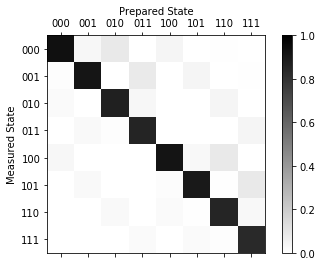

Average Measurement Fidelity: 0.885193 

The calibration matrix 

[[9.52880859e-01 3.27148438e-02 3.28369141e-02 1.22070312e-03
  3.43017578e-02 1.34277344e-03 2.19726562e-03 0.00000000e+00]
 [1.02539062e-02 9.31884766e-01 3.66210938e-04 3.12500000e-02
  0.00000000e+00 3.25927734e-02 0.00000000e+00 1.34277344e-03]
 [1.04980469e-02 3.66210938e-04 9.32495117e-01 3.33251953e-02
  2.44140625e-04 0.00000000e+00 3.06396484e-02 1.46484375e-03]
 [1.22070312e-04 1.08642578e-02 1.29394531e-02 8.80737305e-01
  0.00000000e+00 3.66210938e-04 4.88281250e-04 3.64990234e-02]
 [2.58789062e-02 3.66210938e-04 1.09863281e-03 1.79443359e-02
  9.42504883e-01 3.24707031e-02 4.04052734e-02 1.58691406e-03]
 [2.44140625e-04 2.35595703e-02 0.00000000e+00 2.07519531e-03
  1.22070312e-02 9.23095703e-01 0.00000000e+00 3.23486328e-02]
 [1.22070312e-04 0.00000000e+00 1.98974609e-02 3.29589844e-03
  1.04980469e-02 2.44140625e-04 9.14306641e-01 3.34472656e-02]
 [0.00000000e+00 2.44140625e-04 3.66210938e-04 3.01513672e-

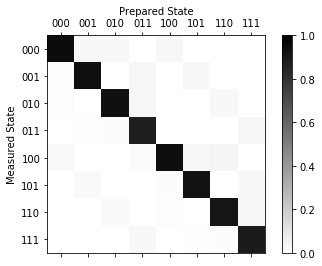

Average Measurement Fidelity: 0.921402 

The calibration matrix 

[[9.43847656e-01 3.22265625e-02 1.04248047e-01 4.02832031e-03
  3.25927734e-02 3.66210938e-04 3.17382812e-03 2.44140625e-04]
 [1.24511719e-02 9.27001953e-01 1.46484375e-03 1.02294922e-01
  4.88281250e-04 3.23486328e-02 0.00000000e+00 4.27246094e-03]
 [2.05078125e-02 9.76562500e-04 8.64135742e-01 2.80761719e-02
  1.22070312e-03 0.00000000e+00 3.27148438e-02 8.54492188e-04]
 [1.22070312e-04 1.94091797e-02 9.39941406e-03 8.39233398e-01
  0.00000000e+00 9.76562500e-04 2.44140625e-04 3.06396484e-02]
 [2.24609375e-02 4.88281250e-04 1.58691406e-03 1.22070312e-04
  9.32861328e-01 3.19824219e-02 9.59472656e-02 5.61523438e-03]
 [4.88281250e-04 1.92871094e-02 1.22070312e-04 3.17382812e-03
  9.88769531e-03 9.13085938e-01 8.54492188e-04 9.75341797e-02]
 [1.22070312e-04 0.00000000e+00 1.85546875e-02 1.09863281e-03
  2.27050781e-02 8.54492188e-04 8.57421875e-01 3.12500000e-02]
 [0.00000000e+00 6.10351562e-04 4.88281250e-04 2.19726562e-

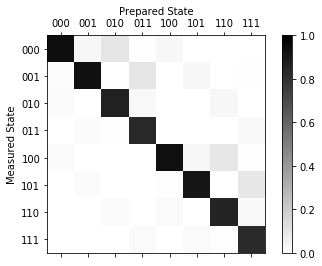

Average Measurement Fidelity: 0.888397 

The calibration matrix 

[[9.39941406e-01 8.86230469e-02 3.54003906e-02 3.66210938e-03
  3.73535156e-02 3.29589844e-03 1.58691406e-03 2.44140625e-04]
 [2.51464844e-02 8.75610352e-01 1.83105469e-03 3.40576172e-02
  1.22070312e-03 3.91845703e-02 0.00000000e+00 9.76562500e-04]
 [1.17187500e-02 2.19726562e-03 9.09667969e-01 8.37402344e-02
  2.19726562e-03 4.88281250e-04 4.06494141e-02 3.66210938e-03]
 [2.44140625e-04 1.06201172e-02 2.56347656e-02 8.54125977e-01
  0.00000000e+00 1.95312500e-03 1.58691406e-03 3.88183594e-02]
 [2.13623047e-02 1.70898438e-03 1.22070312e-03 2.44140625e-04
  9.18090820e-01 8.93554688e-02 3.64990234e-02 3.41796875e-03]
 [6.10351562e-04 2.08740234e-02 1.22070312e-04 9.76562500e-04
  2.57568359e-02 8.49487305e-01 5.98144531e-03 3.21044922e-02]
 [9.76562500e-04 1.22070312e-04 2.57568359e-02 2.44140625e-03
  1.45263672e-02 4.76074219e-03 8.90502930e-01 8.14208984e-02]
 [0.00000000e+00 2.44140625e-04 3.66210938e-04 2.07519531e-

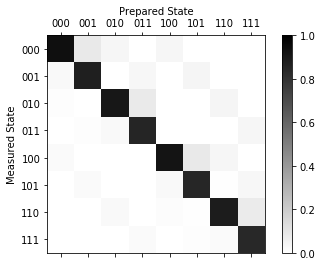

Average Measurement Fidelity: 0.884598 

The calibration matrix 

[[9.39208984e-01 9.16748047e-02 2.89306641e-02 3.41796875e-03
  4.11376953e-02 5.12695312e-03 2.19726562e-03 0.00000000e+00]
 [2.58789062e-02 8.73535156e-01 1.09863281e-03 2.74658203e-02
  1.46484375e-03 4.11376953e-02 0.00000000e+00 9.76562500e-04]
 [1.07421875e-02 1.22070312e-03 9.19189453e-01 8.37402344e-02
  4.88281250e-04 0.00000000e+00 4.05273438e-02 3.41796875e-03]
 [6.10351562e-04 9.52148438e-03 2.46582031e-02 8.60839844e-01
  1.22070312e-04 3.66210938e-04 1.46484375e-03 3.73535156e-02]
 [2.23388672e-02 1.70898438e-03 3.66210938e-04 3.66210938e-04
  9.21752930e-01 9.41162109e-02 3.33251953e-02 3.29589844e-03]
 [8.54492188e-04 2.17285156e-02 1.22070312e-04 8.54492188e-04
  2.39257812e-02 8.48876953e-01 8.54492188e-04 3.08837891e-02]
 [3.66210938e-04 0.00000000e+00 2.42919922e-02 2.19726562e-03
  1.07421875e-02 8.54492188e-04 8.96728516e-01 7.99560547e-02]
 [0.00000000e+00 6.10351562e-04 1.34277344e-03 2.11181641e-

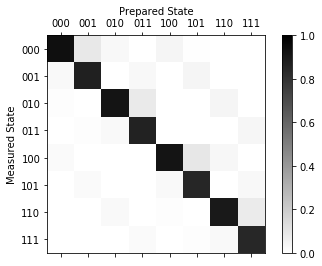

Average Measurement Fidelity: 0.888031 

The calibration matrix 

[[9.18701172e-01 3.89404297e-02 1.49902344e-01 7.93457031e-03
  9.85107422e-02 5.37109375e-03 1.90429688e-02 9.76562500e-04]
 [2.03857422e-02 9.01733398e-01 2.92968750e-03 1.46606445e-01
  2.07519531e-03 9.72900391e-02 2.44140625e-04 1.83105469e-02]
 [3.28369141e-02 1.34277344e-03 8.06762695e-01 3.30810547e-02
  4.39453125e-03 3.66210938e-04 8.72802734e-02 3.05175781e-03]
 [1.09863281e-03 2.86865234e-02 1.68457031e-02 7.82958984e-01
  3.66210938e-04 4.15039062e-03 1.95312500e-03 7.56835938e-02]
 [2.44140625e-02 9.76562500e-04 3.90625000e-03 7.32421875e-04
  8.48388672e-01 3.84521484e-02 1.37817383e-01 6.34765625e-03]
 [1.22070312e-03 2.58789062e-02 2.44140625e-04 5.24902344e-03
  1.90429688e-02 8.28247070e-01 3.41796875e-03 1.32202148e-01]
 [1.22070312e-03 8.54492188e-04 1.84326172e-02 6.10351562e-04
  2.57568359e-02 1.70898438e-03 7.33276367e-01 2.97851562e-02]
 [1.22070312e-04 1.58691406e-03 9.76562500e-04 2.28271484e-

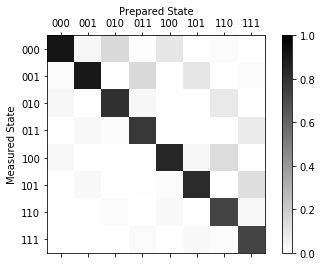

Average Measurement Fidelity: 0.819214 

The calibration matrix 

[[9.16381836e-01 1.34521484e-01 3.06396484e-02 4.39453125e-03
  8.98437500e-02 1.81884766e-02 3.66210938e-03 1.09863281e-03]
 [3.12500000e-02 8.11645508e-01 1.22070312e-03 2.92968750e-02
  3.54003906e-03 8.27636719e-02 3.66210938e-04 1.95312500e-03]
 [2.02636719e-02 3.17382812e-03 9.07592773e-01 1.37573242e-01
  3.41796875e-03 3.66210938e-04 8.81347656e-02 1.81884766e-02]
 [8.54492188e-04 1.69677734e-02 2.77099609e-02 7.96386719e-01
  1.22070312e-04 1.83105469e-03 2.92968750e-03 7.67822266e-02]
 [2.80761719e-02 4.76074219e-03 1.22070312e-03 2.44140625e-04
  8.57421875e-01 1.22558594e-01 2.74658203e-02 6.22558594e-03]
 [1.95312500e-03 2.80761719e-02 1.22070312e-04 1.70898438e-03
  2.55126953e-02 7.54394531e-01 1.22070312e-03 2.79541016e-02]
 [9.76562500e-04 1.22070312e-04 3.02734375e-02 4.02832031e-03
  1.91650391e-02 2.68554688e-03 8.46557617e-01 1.18530273e-01]
 [2.44140625e-04 7.32421875e-04 1.22070312e-03 2.63671875e-

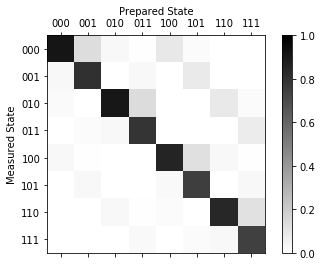

Average Measurement Fidelity: 0.829956 



In [28]:
meas_fitter_list = []

for result_cal_exp in result_cal_exp_list:
    
    ## define measurement fitter
    meas_fitter = CompleteMeasFitter(result_cal_exp, state_labels)
    meas_fitter_list.append(meas_fitter)
    
    print("The calibration matrix \n")
    print(meas_fitter.cal_matrix)

    ## Plot the calibration matrix
    print("Plot the calibration matrix (2D color grid plot)\n")
    meas_fitter.plot_calibration()

    ## The measurement fidelity
    print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity(), "\n")

### Apply device calibration parameter to mitigate the result_exp

In [29]:
## define the list to store 
mitigated_m_list = []
mitigated_ix_list = []

## define repeat length
in_len = len(init_list)

## repeat (num_qubits) times
for result_exp, meas_fitter in zip(result_exp_list, meas_fitter_list):
    
    # Get the filter object
    meas_filter = meas_fitter.filter
    
    ## get measurement error mitigated result
    mitigated_results = meas_filter.apply(result_exp)
    mitigated_m_counts = [mitigated_results.get_counts(init) for init in range(in_len)]
    mitigated_ix_counts = [mitigated_results.get_counts(init) for init in range(in_len, 2*in_len)]
    
    ## Append mitigated_counts to mitigated_list
    mitigated_m_list.append(mitigated_m_counts)
    mitigated_ix_list.append(mitigated_ix_counts)

### Show the mitigated counts

In [30]:
print("mitigated_m_counts = ", mitigated_m_list, "\n")
print("mitigated_is_counts = ", mitigated_m_list, "\n")

mitigated_m_counts =  [[{'000': 7730.99356943653, '010': 26.945493151202363, '011': 6.44739744177971e-11, '001': 434.0609374124809, '111': 1.2767185854530017e-11, '110': 6.888233961086648e-12}, {'000': 220.5898503970862, '101': 3.268802763189971e-11, '010': 0.22938358476191856, '100': 2.550014019386815e-12, '001': 7971.180766018129}, {'000': 81.68042739395067, '100': 1.0425348086987724e-09, '010': 7758.129378939779, '011': 302.9195386135675, '001': 17.098664396308006, '111': 32.17199064590954, '110': 9.618097682987e-09}, {'101': 2.0016015013907303e-09, '010': 93.35813658240839, '100': 1.52040814634026e-08, '011': 8098.641863388925, '111': 2.1843998371981033e-08}, {'000': 208.65691933789915, '101': 274.86002946024996, '010': 1.6736818309783376e-11, '100': 7627.859346290967, '001': 7.33881405688648, '111': 73.28489085381509, '110': 1.6790812891551848e-10}, {'000': 1.442456300788785, '101': 7770.201285933392, '010': 8.156893872368967e-11, '100': 162.1985571626297, '001': 198.4986948862230

### post data processing

In [31]:
## define length of repeat
input_len = len(mitigated_m_list)
output_bin = [format(num, '03b') for num in range(8)]


mit_m_data = [[[(mitigated_m_list[mapping][inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)] for mapping in range(len(job_id_list))]
mit_ix_data = [[[(mitigated_ix_list[mapping][inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)] for mapping in range(len(job_id_list))]

In [32]:
print("mit_m_data = ",mit_m_data, "\n")
print("mit_ix_data = ",mit_ix_data, "\n")

mit_m_data =  [[[0.9437248009566077, 0.05298595427398448, 0.0032892447694338823, 7.870358205297498e-15, 0.0, 0.0, 8.4084887220296e-16, 1.5584943670080587e-15], [0.02692747197230056, 0.9730445271018224, 2.8000925874257636e-05, 0.0, 3.1128100822592954e-16, 3.990237748034632e-15, 0.0, 0.0], [0.009970755297113118, 0.002087239306189942, 0.9470372777026097, 0.036977482740914, 1.2726254988998686e-13, 0.0, 1.174084189817749e-12, 0.003927244951893254], [0.0, 0.0, 0.011396256907032274, 0.9886037430894684, 1.855966975513013e-12, 2.4433612077523564e-13, 0.0, 2.666503707517216e-12], [0.025470815348864643, 0.0008958513253035254, 2.0430686413309785e-15, 0.0, 0.931135174107784, 0.03355224968997192, 2.0496597768007627e-14, 0.0089459095280536], [0.00017608109140488098, 0.024230797715603398, 9.95714584029415e-15, 0.0, 0.01979962855989132, 0.948510899161791, 0.007282593471355782, 0.0], [0.0005267197348981244, 6.033775516376372e-05, 0.013497305638637842, 0.011417715202049436, 0.011792725818026114, 0.0, 0.0

In [33]:
def two_matrices_mean(matrix1, matrix2):
    mean = [[(col_0+col_1)/2 for col_0, col_1 in zip(row_0, row_1)] for row_0, row_1 in zip(matrix1, matrix2)]
    return mean

def matrices_mean(array):
    mat = array[0]
    len_mat = len(array)
    for i in range(1, len_mat):
        res = two_matrices_mean(mat, array[i])
        mat = res
    return mat

In [34]:
mit_m_mean = matrices_mean(mit_m_data)
mit_ix_mean = matrices_mean(mit_ix_data)

In [35]:
print("mit_m_mean = ",mit_m_mean)
print("mit_ix_mean = ", mit_ix_mean)

mit_m_mean =  [[0.7171944622388302, 0.21500668531178907, 0.01765584289731996, 0.023420654134405226, 0.018422240526858404, 0.002688252229387171, 0.002552628383410988, 0.003059234277999784], [0.18132848097973342, 0.7598894863353235, 0.013512689789962673, 0.01921450055066691, 0.003650516399106336, 0.01723502397358896, 0.0021084613556043305, 0.0030608406160279383], [0.024993348589109208, 0.033491455427973466, 0.8370053509179278, 0.06958248729495306, 0.0004996238439056423, 0.001519417877621322, 0.0010914028971808734, 0.03181691315153126], [0.029008289549820813, 0.020931837111299523, 0.040663510224470914, 0.8737361500800845, 0.0018392810059111831, 0.0002748998270011702, 0.033546032201474896, 5.686830132506643e-14], [0.04117953865538437, 0.036446241071989675, 0.0005397800603845428, 0.0066640124609023835, 0.787279758423586, 0.08053440503995007, 0.01811732374552977, 0.029238940542680125], [0.02910739970951207, 0.028361192548489744, 0.004696904444141798, 0.002443645551523642, 0.06478318350596834

### Plot the output matrix

In [1]:
## import tools
## Import numpy 
import numpy as np
from numpy import pi

## import plot tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
## To plot heatmap
import seaborn as sns

In [17]:
mean_m =  [[0.7171944622388302, 0.21500668531178907, 0.01765584289731996, 0.023420654134405226, 0.018422240526858404, 0.002688252229387171, 0.002552628383410988, 0.003059234277999784], [0.18132848097973342, 0.7598894863353235, 0.013512689789962673, 0.01921450055066691, 0.003650516399106336, 0.01723502397358896, 0.0021084613556043305, 0.0030608406160279383], [0.024993348589109208, 0.033491455427973466, 0.8370053509179278, 0.06958248729495306, 0.0004996238439056423, 0.001519417877621322, 0.0010914028971808734, 0.03181691315153126], [0.029008289549820813, 0.020931837111299523, 0.040663510224470914, 0.8737361500800845, 0.0018392810059111831, 0.0002748998270011702, 0.033546032201474896, 5.686830132506643e-14], [0.04117953865538437, 0.036446241071989675, 0.0005397800603845428, 0.0066640124609023835, 0.787279758423586, 0.08053440503995007, 0.01811732374552977, 0.029238940542680125], [0.02910739970951207, 0.028361192548489744, 0.004696904444141798, 0.002443645551523642, 0.06478318350596834, 0.8238633169297862, 0.024025515539537697, 0.022718841771243774], [0.003054821522719589, 0.0016130781023335798, 0.04997409148662972, 0.02134176352134439, 0.05571169204622434, 0.022101527233340485, 0.04187782198033282, 0.8043252041088553], [2.5441448822886435e-05, 0.0016401648607367652, 0.01704892054538678, 0.06441511798458766, 0.011577274139940348, 0.05327255063242685, 0.7873791535539396, 0.0646413768341775]]
mean_ix =  [[0.7941103145740691, 0.12732937571472147, 0.026425794467413874, 0.017551058786849344, 0.024999277920939984, 0.0036049378704296614, 0.0017797974140494107, 0.004199443251530573], [0.09339730997140619, 0.8425026941021576, 0.014235056047886017, 0.022884965256367757, 0.005645912386507733, 0.01648945554060993, 0.0028937727193680597, 0.0019508339761721933], [0.017190678621419358, 0.023433681716009007, 0.8279049240674088, 0.08531503949600616, 0.0038619483082249287, 0.002306953036164821, 0.002379532121975805, 0.037607242632881926], [0.010899996211747845, 0.015573554147351364, 0.0668628780919533, 0.8667576555450603, 0.0017305397250389845, 0.002160651709535894, 0.036014724569802106, 4.8430043236562555e-14], [0.03590636574676446, 0.020983527156158838, 0.006029845787328338, 0.005370047354259182, 0.8144509056892582, 0.06947457821097702, 0.005572880844194603, 0.04221184921109976], [0.015429340543014546, 0.03346109411909056, 0.002058461244182587, 0.0055519900498896685, 0.04627131854587885, 0.8483122727316554, 0.04485259672934941, 0.004062926036997311], [0.000654326906214663, 0.0023518693664114094, 0.03429755088079156, 0.020876832177106182, 0.04768393852785276, 0.02040460865762468, 0.04187650061145877, 0.8318543728731342], [1.171452362710456e-16, 0.0008050499435134485, 0.017129625095115345, 0.04626525117362273, 0.01414075618364042, 0.040476353772313, 0.8160747381446228, 0.06510822569694961]]

In [18]:
shots = 8192
device = 'ibmq_ourense'

mean_m = [[round(pro, 3) if pro>0 else 0 for pro in mapping] for mapping in mean_m]
mean_ix = [[round(pro, 3) if pro>0 else 0 for pro in mapping] for mapping in mean_ix]

########################## R-Toffoli_m ############################


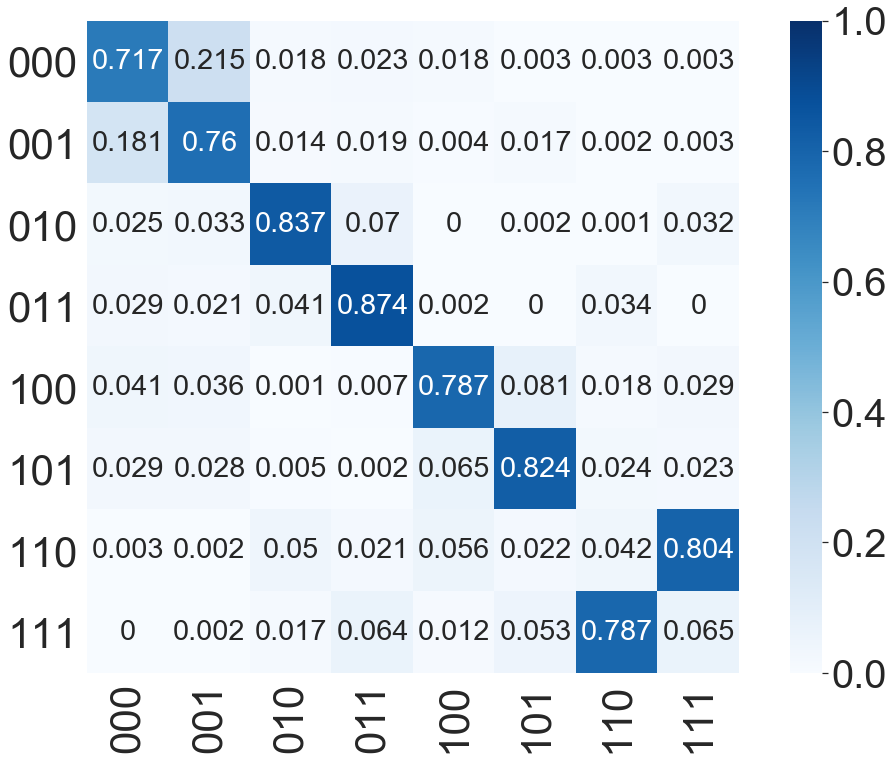

########################## R-Toffoli_ix ############################


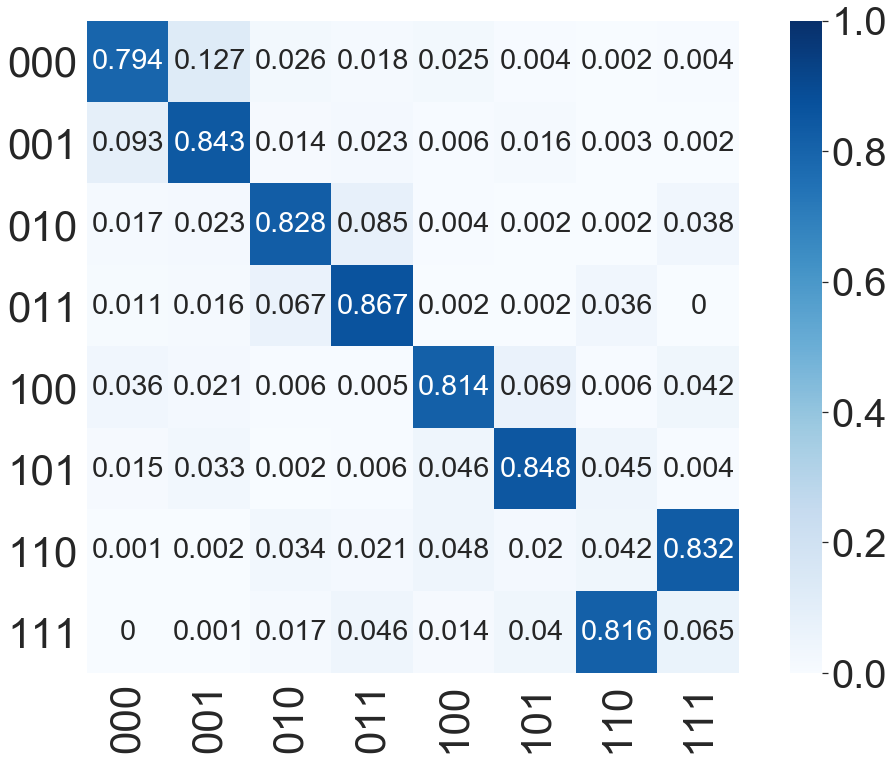

In [21]:
print("########################## R-Toffoli_m ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(8)]
### labels 
X = [format(num, "03b") for num in range(8)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
# ## title
# plt.title("R-Toffoli_m on "+str(device)+"\n", 
#           fontsize=20
#          )

## plot data
sns.set(font_scale=2.4)
sns.heatmap(mean_m, 
            vmin = 0.0,  ## define maximum value
            vmax=1,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues'), ## define the color
#             cbar_kws = dict(ticks=[0, 2048, 4096, 6144, 8192]),
            fmt='g',
           )
cax = ax.collections[0].colorbar.ax # ColorbarオブジェクトからカラーバーのAxesオブジェクトにアクセス
# cax = fig.axes[-1] # これでもよい
cax.tick_params(which='minor', direction='in')
cax.tick_params(which='major', labelsize=40)

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=42
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=42)

plt.savefig("RTof_m_ourense_20191224.png", dpi=200, bbox_inches="tight", pad_inches=0.1)
plt.show()

print("########################## R-Toffoli_ix ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(8)]
### labels 
X = [format(num, "03b") for num in range(8)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
# ## title
# plt.title("R-R-Toffoli_ix on "+str(device)+"\n", 
#           fontsize=20
#          )

## plot data
sns.set(font_scale=2.4)
sns.heatmap(mean_ix, 
            vmin = 0.0,  ## define maximum value
            vmax=1,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues'), ## define the color
#            cbar_kws = dict(ticks=[0, 2048, 4096, 6144, 8192]),
            fmt='g',
           )
cax = ax.collections[0].colorbar.ax # ColorbarオブジェクトからカラーバーのAxesオブジェクトにアクセス
# cax = fig.axes[-1] # これでもよい
cax.tick_params(which='minor', direction='in')
cax.tick_params(which='major', labelsize=40)

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=42
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=42)

plt.savefig("RTof_ix_ourense_20191224.png", dpi=200, bbox_inches="tight", pad_inches=0.1)
plt.show()

---
# Check Fidelity

In [37]:
# mit_m_mean =  [[0.7171944623674474, 0.21500668528644362, 0.017655842603061446, 0.023420654326006984, 0.018422240525103425, 0.0026882522363032096, 0.002552628380685403, 0.0030592342749495623], [0.18132848092124731, 0.7598894859417831, 0.013512686299213449, 0.01921450168169151, 0.003650516398345169, 0.017235026829454204, 0.0021084613133509314, 0.0030608406149265736], [0.024993348515864888, 0.03349146457732101, 0.8370053594442277, 0.0695824528670163, 0.0004996248556260318, 0.0015194176465701567, 0.0010913969724541397, 0.03181693512183661], [0.029008270665091512, 0.020931836976223635, 0.04066351578566305, 0.873736162657633, 0.0018392744041589226, 0.0002749084044854577, 0.03354603110770374, 2.2506836994218825e-14], [0.04117953862052712, 0.03644623393631726, 0.000539780045912394, 0.0066640125482966, 0.7872797642870075, 0.08053440947494281, 0.018117323738124913, 0.029238937348882138], [0.029107399716312054, 0.028361199535028768, 0.004696904441380319, 0.002443645550659202, 0.06478318391085638, 0.8238633167893605, 0.02402550827874393, 0.02271884177800426], [0.0030548212489908814, 0.001613078121861087, 0.04997412770239317, 0.021341762241903844, 0.05571171904957922, 0.02210152724877356, 0.04187776365491429, 0.8043252007317288], [2.544148993318448e-05, 0.0016401556614745003, 0.01704892088297688, 0.06441514235729365, 0.01157728974301267, 0.053272548091789565, 0.7873791695028514, 0.06464133227093445]]
# mit_ix_mean =  [[0.7941103145307671, 0.12732937578877357, 0.026425794507194192, 0.01755105866484184, 0.024999277940565726, 0.003604937948166792, 0.001779797414418116, 0.004199443205274998], [0.0933973099846104, 0.8425027040723725, 0.014235056223704474, 0.02288496219469834, 0.005645912065001257, 0.01648944881145458, 0.002893772557297091, 0.0019508340914123376], [0.01719067225768545, 0.023433691614296218, 0.827904917786304, 0.08531503818837749, 0.0038619510638468833, 0.0023069508155327692, 0.00237953212344371, 0.03760724615057577], [0.010899977494487198, 0.015573556679147615, 0.06686288905332988, 0.8667576453859769, 0.001730538277660187, 0.002160650325835316, 0.03601474278368962, 2.1378444145812957e-14], [0.035906365721421585, 0.020983525994835987, 0.006029845780341823, 0.005370046704892884, 0.8144509070831422, 0.069474578441873, 0.0055728808373464, 0.04221184943614821], [0.015429340541514923, 0.033461101126881235, 0.0020584612059426246, 0.005551990091612111, 0.04627131206929197, 0.848312280474136, 0.04485258843146653, 0.004062926060185528], [0.0006543268303210431, 0.0023518693013888183, 0.034297544904424895, 0.020876831487536357, 0.0476839193376046, 0.020404608723789342, 0.04187652527420608, 0.8318543741431629], [3.0719785142286455e-16, 0.000805049476596193, 0.01712962546481306, 0.04626529546961036, 0.014140755834804153, 0.04047636205313616, 0.8160748667871742, 0.06510804492328343]]
# sim_data_m = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]]
# sim_data_ix = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]]

In [38]:
dens_exp_m = [[col/8 for col in row] for row in mit_m_mean]
dens_sim_m = [[col/8 for col in row] for row in sim_data_m]
dens_exp_ix = [[col/8 for col in row] for row in mit_ix_mean]
dens_sim_ix = [[col/8 for col in row] for row in sim_data_ix]
dens_exp_swaptof = [[col/8 for col in row] for row in mean_swaptof]
dens_sim_swaptof = [[col/8 for col in row] for row in sim_data_swaptof]

NameError: name 'mean_swaptof' is not defined

In [ ]:
F_m = np.trace(np.sqrt(np.dot(dens_exp_m, dens_sim_m)))
F_ix = np.trace(np.sqrt(np.dot(dens_exp_ix, dens_sim_ix)))
F_swaptof = np.trace(np.sqrt(np.dot(dens_exp_swaptof, dens_sim_swaptof)))
print("F_m = ", F_m, "\n")
print("F_ix = ", F_ix, "\n")
print("F_swap = ", F_swap, "\n")